## Creating loadshapes for multiple loads

### With Temperatures from 2017 for heatpump

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import os
import time

## Define Input Parameters

In [2]:
start = time.time()

#Input for el. base energy demand as CSV-File!
#include Base Szenario...
EL_INPUT = './Input_House/Base_Szenario/loads-p_set.csv'
#...or modify existing scenario
#EL_INPUT = './Results/BEV_Szenario/BEV_22_kW_3pH/loads-p_set.csv'


#Output for df_main at the end of House_Calculations
OUTPUT = './Results/'
SZENARIO = 'V1'
if not os.path.exists(OUTPUT + SZENARIO):
    os.makedirs(OUTPUT + SZENARIO)

In [3]:
#Graphs
fontsize = 16

#define the intervall in which the loadshape is divided. 
#NOTICE: Base electricity demand needs to have the same intervalls

#time_base = 1 #for hourly loadshapes
time_base = 15/60 #for loadshapes with steps, smaller than one hour (eg. 15 minutes)

#Input PV
pv_percentage = 10 #%
pv_size = 8.7 #power in kWp
#pv_generation = pd.read_pickle("./Input_House/PV/Solar_Reference_PLZ_5_H.pkl") #hourly timebase
pv_generation = pd.read_csv("./Input_House/PV/SMA_Solar_Data-PLZ5-NP-2011.csv") #15-min timebase
pv_generation.reset_index(inplace = True)

#Input heatpump
hp_percentage = 10 #%
#Choose heatpump type by commenting out irrelevant type
heatpump_type = "Air"
#heatpump_type = "Ground"

heatpump_power_lst = [10.6, 14.5, 18.5] #kW
thermal_power = True #is heatpump_power_lst above electrical (False) or thermal (True) power?
#Hours of usage per year. According to BDEW multi family homes: 2000, single family homes: 2100
hours_year = 2000
water_temp = 60 #°C
#Building Type: 'DE_HMF' for multi family homes, 'DE_HEF' for single family homes
building_type_lst = ['DE_HMF33','DE_HMF34']
#building_type_lst = ['DE_HEF33','DE_HEF34']

#define load which is not a private household
school = '21'
heatpump_power_school = 39.6 #kW
building_type_school = 'DE_GKO34'

#Input electric vehicle
bev_percentage = 10 #%

efficiency = 0.98
charging_power = 11 #kW
battery_charge = 8 #starting state of charge in kWh
battery_max = 20 #max capacity in kWh
battery_min = 2 #min capacity in kWh
battery_usage = 1 #kW, discharge car battery with battery_usage * time_base. Determines charge needed when returned home
weekend_trip_start = ['08:00:00', '08:15:00', '08:30:00', '08:45:00', '09:00:00', '09:15:00','09:30:00','09:45:00',
                      '10:00:00', '10:15:00', '10:30:00', '10:45:00', '11:00:00', '11:15:00', '11:30:00', '11:45:00', 
                      '12:00:00', '12:15:00', '12:30:00', '12:45:00', '13:00:00']

weekend_trip_end = ['17:00:00', '17:15:00', '17:30:00', '17:45:00', '18:00:00', '18:15:00', '18:30:00', '18:45:00', 
                    '19:00:00', '19:15:00', '19:30:00', '19:45:00', '20:00:00', '20:15:00', '20:30:00', '20:45:00', 
                    '21:00:00', '21:15:00', '21:30:00', '21:45:00', '22:00:00', '22:15:00', '22:30:00', '22:45:00', 
                    '23:00:00']

work_start = ['07:00:00', '07:15:00', '07:30:00', '07:45:00', '08:00:00', '08:15:00', '08:30:00', '08:45:00', 
              '09:00:00']

work_end = ['16:00:00', '16:15:00', '16:30:00', '16:45:00', 
            '17:00:00', '17:15:00', '17:30:00', '17:45:00', '18:00:00', '18:15:00', '18:30:00', '18:45:00', 
            '19:00:00', '19:15:00', '19:30:00', '19:45:00', '20:00:00', '20:15:00', '20:30:00', '20:45:00', 
            '21:00:00', '21:15:00', '21:30:00', '21:45:00', '22:00:00']

#Input Home Storage
storage_percentage = 100 #%

nr_storage = 1
storage_max = nr_storage*8.7/1000  #Capacity in MWh
charger_power = nr_storage*3.3/1000 #Charging power in MW
init_storage_charge = 0.0 #Current state of charge

## Start of  calculations

In [4]:
#Include electricity demand of house

df_main = pd.read_csv(EL_INPUT)

#If index of df_main is not set, calculations below will cause error
df_main.set_index(df_main.Time, inplace = True)
del df_main['Time']
df_main.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.002356,0.002356,0.002356,0.002356,0.002356,0.002260,0.002260,0.002260,0.002260,0.002260,...,0.002889,0.002889,0.002173,0.002173,0.002173,0.002173,0.002173,0.002173,0.002173,0.015322
2017-01-01 00:15:00,0.003203,0.003203,0.003203,0.003203,0.003203,0.002173,0.002173,0.002173,0.002173,0.002173,...,0.001973,0.001973,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.015829
2017-01-01 00:30:00,0.003044,0.003044,0.003044,0.003044,0.003044,0.002044,0.002044,0.002044,0.002044,0.002044,...,0.002235,0.002235,0.002112,0.002112,0.002112,0.002112,0.002112,0.002112,0.002112,0.015117
2017-01-01 00:45:00,0.003379,0.003379,0.003379,0.003379,0.003379,0.002003,0.002003,0.002003,0.002003,0.002003,...,0.002021,0.002021,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.015275
2017-01-01 01:00:00,0.003038,0.003038,0.003038,0.003038,0.003038,0.001866,0.001866,0.001866,0.001866,0.001866,...,0.001857,0.001857,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.015304


In [5]:
#Determine distribution of pv, heatpumps, bevs and el storage
pv_installations = int(round((len(df_main.columns) * (pv_percentage/100)), 0))
houses_with_pv = random.sample(list(df_main.columns), pv_installations)

hp_installations = int(round((len(df_main.columns) * (hp_percentage/100)), 0))
houses_with_hp = random.sample(list(df_main.columns), hp_installations)

bevs = int(round((len(df_main.columns) * (bev_percentage/100)), 0))
houses_with_bev = random.sample(list(df_main.columns), bevs)

#Distribution of el storage is only done for houses with pv
storage_installations = int(round((len(houses_with_pv) * (storage_percentage/100)), 0))
houses_with_storage = random.sample(houses_with_pv, storage_installations)

In [6]:
df = pd.DataFrame(df_main.index) #dataframe for loops
df_main.reset_index(inplace = True) #reset index, otherwise df_main results with NaNs

if len(houses_with_pv) > 0:
    for column in df_main.columns:

        if column in houses_with_pv:
            df['House_Demand'] = df_main[column] #add data to processing data frame
            #pick kWp from a list at this point for each house to differ loadshapes??
            df['PV_Generation'] = pd.DataFrame((pv_size/1000) * pv_generation.Generation)

            #calculation of new loadshapes       
            df_main[column] = df.House_Demand - df.PV_Generation #PV_Generation reduces House_Demand

In [7]:
df_main.head(24)

,Time,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,2017-01-01 00:00:00,0.002356,0.002356,0.002356,0.002356,0.002356,0.002260,0.002260,0.002260,0.002260,...,0.002889,0.002889,0.002173,0.002173,0.002173,0.002173,0.002173,0.002173,0.002173,0.015322
1,2017-01-01 00:15:00,0.003203,0.003203,0.003203,0.003203,0.003203,0.002173,0.002173,0.002173,0.002173,...,0.001973,0.001973,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.015829
2,2017-01-01 00:30:00,0.003044,0.003044,0.003044,0.003044,0.003044,0.002044,0.002044,0.002044,0.002044,...,0.002235,0.002235,0.002112,0.002112,0.002112,0.002112,0.002112,0.002112,0.002112,0.015117
3,2017-01-01 00:45:00,0.003379,0.003379,0.003379,0.003379,0.003379,0.002003,0.002003,0.002003,0.002003,...,0.002021,0.002021,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.015275
4,2017-01-01 01:00:00,0.003038,0.003038,0.003038,0.003038,0.003038,0.001866,0.001866,0.001866,0.001866,...,0.001857,0.001857,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.015304
5,2017-01-01 01:15:00,0.003803,0.003803,0.003803,0.003803,0.003803,0.001771,0.001771,0.001771,0.001771,...,0.001943,0.001943,0.001820,0.001820,0.001820,0.001820,0.001820,0.001820,0.001820,0.014717
6,2017-01-01 01:30:00,0.003766,0.003766,0.003766,0.003766,0.003766,0.001970,0.001970,0.001970,0.001970,...,0.001667,0.001667,0.002021,0.002021,0.002021,0.002021,0.002021,0.002021,0.002021,0.014940
7,2017-01-01 01:45:00,0.003972,0.003972,0.003972,0.003972,0.003972,0.001769,0.001769,0.001769,0.001769,...,0.001631,0.001631,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.014891
8,2017-01-01 02:00:00,0.003526,0.003526,0.003526,0.003526,0.003526,0.001907,0.001907,0.001907,0.001907,...,0.001432,0.001432,0.001785,0.001785,0.001785,0.001785,0.001785,0.001785,0.001785,0.015031
9,2017-01-01 02:15:00,0.003442,0.003442,0.003442,0.003442,0.003442,0.002521,0.002521,0.002521,0.002521,...,0.001684,0.001684,0.001819,0.001819,0.001819,0.001819,0.001819,0.001819,0.001819,0.015370


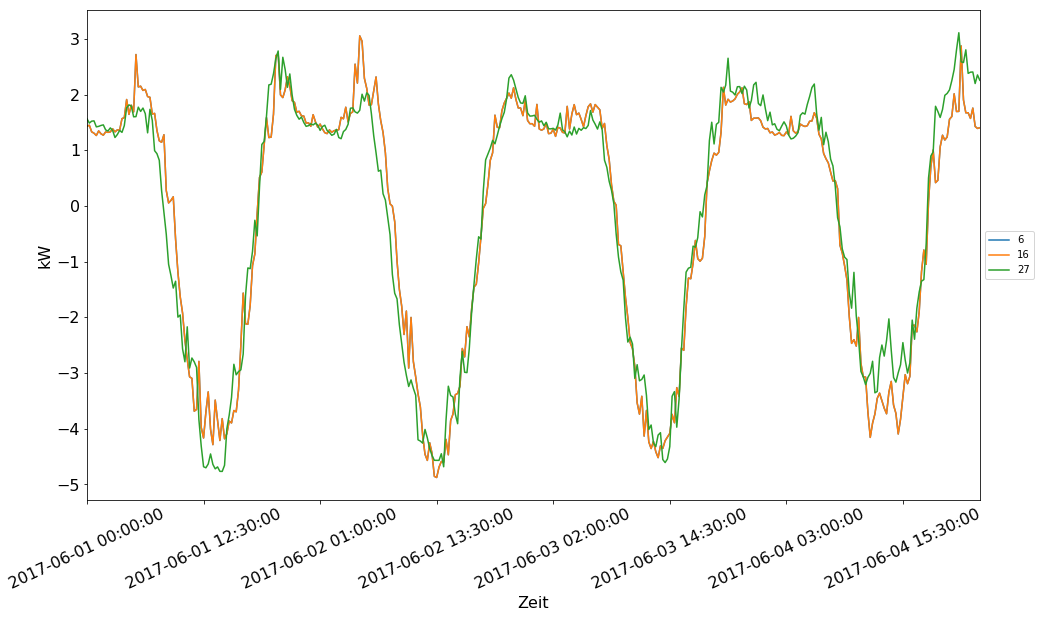

In [8]:
if len(houses_with_storage) > 0:  
    if 'Time' in df_main.columns:
        
        df_main.set_index(df_main.Time, inplace = True)
        del df_main['Time']

    ax1 = plt.subplot()

    for column in df_main.columns:
        if column in houses_with_storage:
            (df_main[column].ix['2017-06-01 00:00:00':'2017-06-04 23:45:00']*1000).plot(figsize = (16,9), ax = ax1)
            #df_main[column].plot(figsize = (16,9), ax = ax1)
            
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(25)
        
    plt.ylabel("kW", fontsize = fontsize)
    plt.xlabel("Zeit", fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(OUTPUT + SZENARIO + '/PV_Haus_ohne_Speicher.png')
    plt.show()
    df_main.reset_index(inplace = True) #reset index, otherwise df_main results with NaNs


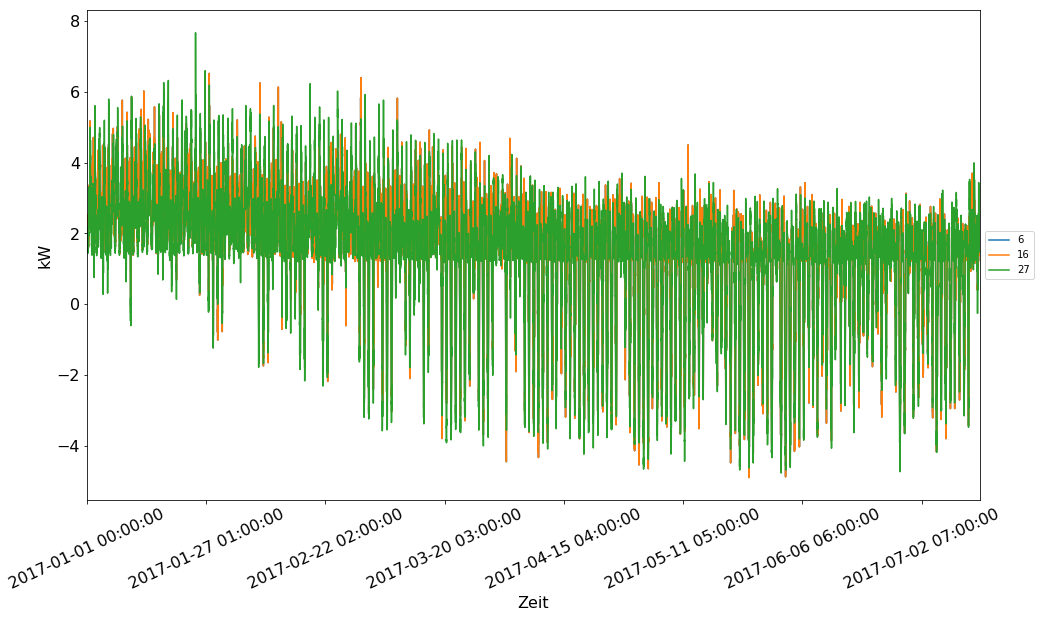

In [9]:
if len(houses_with_pv) > 0:    
    if 'Time' in df_main.columns:
        
        df_main.set_index(df_main.Time, inplace = True)
        del df_main['Time']

    ax1 = plt.subplot()

    for column in df_main.columns:
        if column in houses_with_pv:
            (df_main[column]*1000).plot(figsize = (16,9), ax = ax1)

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(25)
    plt.ylabel("kW", fontsize = fontsize)
    plt.xlabel("Zeit", fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    #plt.title("Häuser mit PV-Anlagen", fontsize = fontsize)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(OUTPUT + SZENARIO + '/houses_with_pv.png')
    plt.show()
    df_main.reset_index(inplace = True) #reset index, otherwise df_main results with NaNs


In [10]:
df_main.head()

,Time,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,2017-01-01 00:00:00,0.002356,0.002356,0.002356,0.002356,0.002356,0.002260,0.002260,0.002260,0.002260,...,0.002889,0.002889,0.002173,0.002173,0.002173,0.002173,0.002173,0.002173,0.002173,0.015322
1,2017-01-01 00:15:00,0.003203,0.003203,0.003203,0.003203,0.003203,0.002173,0.002173,0.002173,0.002173,...,0.001973,0.001973,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.015829
2,2017-01-01 00:30:00,0.003044,0.003044,0.003044,0.003044,0.003044,0.002044,0.002044,0.002044,0.002044,...,0.002235,0.002235,0.002112,0.002112,0.002112,0.002112,0.002112,0.002112,0.002112,0.015117
3,2017-01-01 00:45:00,0.003379,0.003379,0.003379,0.003379,0.003379,0.002003,0.002003,0.002003,0.002003,...,0.002021,0.002021,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.015275
4,2017-01-01 01:00:00,0.003038,0.003038,0.003038,0.003038,0.003038,0.001866,0.001866,0.001866,0.001866,...,0.001857,0.001857,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.015304


In [11]:
#Include E-Mobility loadshape
if len(houses_with_bev) > 0:    
    df = pd.DataFrame(df.Time) #reset dataframe for next loop
    df['Time'] = pd.to_datetime(df['Time'])
    df_Car_Cap = pd.DataFrame(df.Time) #dataframe for bev's state of charge
    df_Charger = pd.DataFrame(df.Time) #dataframe for bev's demand

    for column in df_main.columns:

        if column in houses_with_bev:

            df['House_Demand'] = df_main[column] #add data to processing data frame

            #Add column with Hours to determine start and end of charging
            df2 = pd.DataFrame(df.Time.astype('str').str.split().tolist(), columns="Date Hour".split())
            df['Hour'] = df2.Hour

            #Add weekday: 0 = Monday
            #if 'Time' is already the index use : df['Weekday'] = df.index.weekday
            df['Weekday'] = df['Time'].dt.dayofweek

            #Determine the Times when the car is at home. During the week (d.Weekday < 5) and on the weekend (d.Weekday >= 5).
            #Pick departure and arrival times from the preconfigured list in the section 'Input Data'.
            #(len(...)-1) is necessary because len() starts counting at 1 and randrange() starts indexing at 0

            lst = []

            for i, d in df.iterrows():
                if (d.Hour == '00:00:00') & (d.Weekday < 5):
                    departure = work_start[random.randrange(0,(len(work_start) - 1),1)]
                    arrival = work_end[random.randrange(0,(len(work_end) - 1),1)]

                elif (d.Hour == '00:00:00') & (d.Weekday >= 5):
                    departure = weekend_trip_start[random.randrange(0,(len(weekend_trip_start) - 1),1)]
                    arrival = weekend_trip_end[random.randrange(0,(len(weekend_trip_end) - 1),1)]

                if (d.Hour > arrival) | (d.Hour < departure):
                    lst.append(1) #if at home add 1 to the list
                else:
                    lst.append(0) #if not add 0 to the list

            dfAt_Home = pd.DataFrame(lst)
            df['At_Home'] = dfAt_Home[0] #Include in original Data Frame

            #Determine the charge of the car battery and the power drawn by the charger.
            #The charger power will add to the el. demand of the house.
            #For later implementation in the house model, consider 'grid friendly' charging

            lst_battery = []
            lst_charger = []

            for i, d in df.iterrows():
                if (d.At_Home == 0) & (battery_charge > battery_min):
                    #if car is not at home discharge battery with X kW/h
                    battery_charge = battery_charge - battery_usage * time_base 

                    if battery_charge < battery_min:
                        battery_charge = battery_min

                    lst_battery.append(battery_charge)
                    lst_charger.append(0) #if car is not at home, chargers energy consumption is 0

                #If car is at home, charge with charging power. If timescale is hours charging power results in kWh    
                elif (d.At_Home == 1) & (battery_charge < battery_max): 
                    battery_charge = battery_charge + (charging_power * efficiency * time_base)
                    charger = charging_power

                    #If battery would be overcharged, charge only with kWh left
                    if battery_charge > battery_max:
                        charger = charging_power - (battery_charge - battery_max)
                        battery_charge = battery_max

                    lst_battery.append(battery_charge)
                    lst_charger.append(charger)

                #If battery is full and car is at home, 
                #charger consumes no power and current state of charge of battery is returned
                else:
                    lst_battery.append(battery_charge)
                    lst_charger.append(0)

            dfCar_cap = pd.DataFrame(lst_battery)
            dfCharger = pd.DataFrame(lst_charger)

            #Include in original Data Frame
            df_main[column] = df.House_Demand + dfCharger[0]/1000 #Charger adds to the House_Demand. Convert to MW for PyPSA

            df_Car_Cap[column] = dfCar_cap[0] #Car_Cap is for visualising the current battery capacity of the car
            df_Charger[column] = dfCharger[0] #Charger for visualizing simultaniousness of bev charging in grid

    df_Charger.set_index(df_Charger.Time, inplace = True)
    del df_Charger['Time']
    df_Charger.to_pickle(OUTPUT + SZENARIO +'/df_Charger.pkl')
    df_Car_Cap.set_index(df_Car_Cap.Time, inplace = True)
    del df_Car_Cap['Time']
    df_Car_Cap.to_pickle(OUTPUT + SZENARIO +'/df_Car_Cap.pkl')

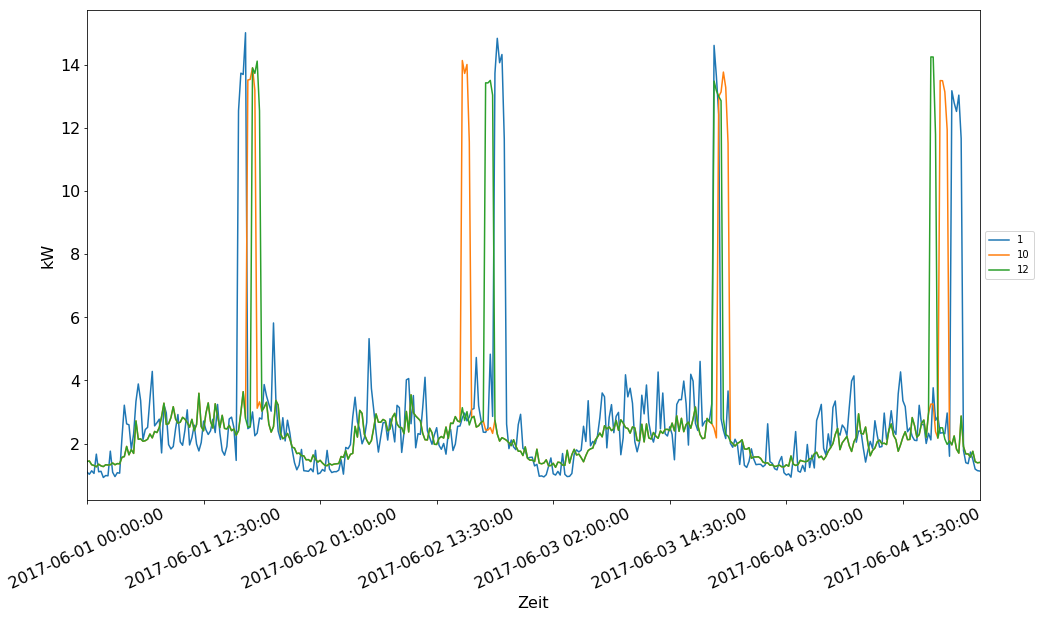

In [12]:
if len(houses_with_bev) > 0:
    
    if 'Time' in df_main.columns:
        df_main.set_index(df_main.Time, inplace = True)
        del df_main['Time']

    ax1 = plt.subplot()

    for column in df_main.columns:
        if column in houses_with_bev:
            (df_main[column].ix['2017-06-01 00:00:00':'2017-06-04 23:45:00']*1000).plot(figsize = (16,9), ax = ax1)

            
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(25)
    plt.ylabel("kW", fontsize = fontsize)
    plt.xlabel("Zeit", fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(OUTPUT + SZENARIO + '/houses_with_bev.png')        
    plt.show()
    df_main.reset_index(inplace = True) #reset index, otherwise df_main results with NaNs


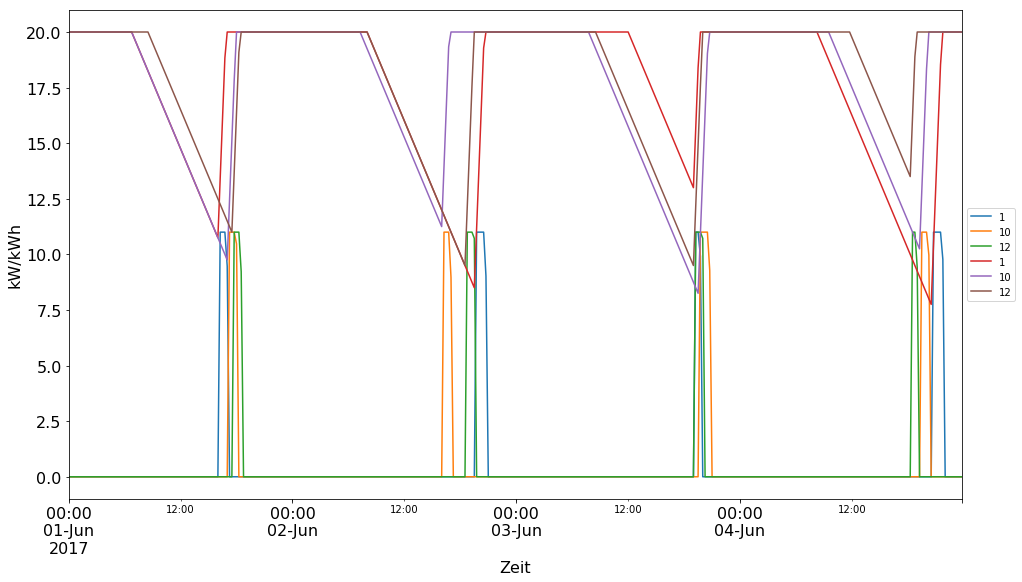

In [13]:
if len(houses_with_bev) > 0:   
    ax1 = plt.subplot()
    
    df_Charger.ix['2017-06-01 00:00:00':'2017-06-04 23:45:00'].plot(figsize = (16,9), ax = ax1)  
    df_Car_Cap.ix['2017-06-01 00:00:00':'2017-06-04 23:45:00'].plot(figsize = (16,9), ax = ax1)        
    
    plt.ylabel("kW/kWh", fontsize = fontsize)
    plt.xlabel("Zeit", fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    #plt.title("Speicherstand", fontsize = fontsize)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(OUTPUT + SZENARIO + '/BEV_Ladeeinrichtung.png')    
    plt.show()

In [14]:
#Include heat demand and COP to calculate heatpump loadshape.
#Power of heatpump is defined in 'Input Data' of House_Calculations


if len(houses_with_hp) > 0:
    
    df_heatpump_power = pd.DataFrame()
    df_building_types = pd.DataFrame()
    
    for column in df_main.columns:

        if column in houses_with_hp:
            
            #select heatpump for current house and building type
            if column == school:
                heatpump_power = heatpump_power_school
                building_types = building_type_school

            else: 
                heatpump_power = heatpump_power_lst[random.randrange(0,(len(heatpump_power_lst)),1)]
                building_type = building_type_lst[random.randrange(0,(len(building_type_lst)),1)]
            
            df_heatpump_power[column] = heatpump_power
            df_building_types[column] = building_type

            SigLinDe = pd.read_csv("./Input_House/heatpump_model/SigLinDe.csv", decimal=",")

            for i, Sig in SigLinDe.iterrows():

                if Sig.Type == building_type:
                    A = Sig.A
                    B = Sig.B
                    C = Sig.C
                    D = Sig.D
                    m_H = Sig.m_H
                    b_H = Sig.b_H
                    m_W = Sig.m_W
                    b_W = Sig.b_W

            df_HP = pd.DataFrame(pd.date_range("2017-01-01","2017-07-15",freq="D", name = 'Time'))
            df_HP['Mean_Temp'] = pd.read_csv("./Input_House/heatpump_model/mean_temp_days_2017.csv", header = None)

            #Calculating the daily heat demand h_del for each day of the year
            h_lst = []
            #Reference temperature for SigLinDe funktion
            t_0 = 40 #°C

            for i, temp in df_HP.iterrows():
                #H and W are for linearisation in SigLinDe function below 8°C
                H = m_H * temp.Mean_Temp + b_H
                W = m_W * temp.Mean_Temp + b_W
                if H > W:
                    h_del = ((A/(1+((B/(temp.Mean_Temp - t_0))**C))) + D) + H
                    h_lst.append(h_del)

                else:
                    h_del = ((A/(1+((B/(temp.Mean_Temp - t_0))**C))) + D) + W
                    h_lst.append(h_del)

            df_h_del = pd.DataFrame(h_lst)
            df_HP['h_del'] = df_h_del[0]

            #import table to distribute daily demand load over 24 hours
            demand_daily = pd.read_csv('./Input_House/heatpump_model/demand_daily.csv')

            demand_daily_lst = []

            for i, d in df_HP.iterrows():


                if (d.Mean_Temp <= -15):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['Temp. <= -15 °C']
                        demand_daily_lst.append(demand)

                elif ((d.Mean_Temp > -15) & (d.Mean_Temp <= -10)):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['-15 °C < Temp. <= -10 °C']
                        demand_daily_lst.append(demand)

                elif ((d.Mean_Temp > -10) & (d.Mean_Temp <= -5)):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['-10 °C < Temp. <= -5 °C']
                        demand_daily_lst.append(demand)

                elif ((d.Mean_Temp > -5) & (d.Mean_Temp <= 0)):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['-5 °C < Temp. <= 0 °C']
                        demand_daily_lst.append(demand)

                elif ((d.Mean_Temp > 0) & (d.Mean_Temp <= 5)):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['0 °C < Temp. <= 5 °C']
                        demand_daily_lst.append(demand)

                elif ((d.Mean_Temp > 5) & (d.Mean_Temp <= 10)):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['5 °C < Temp. <= 10 °C']
                        demand_daily_lst.append(demand)

                elif ((d.Mean_Temp > 10) & (d.Mean_Temp <= 15)):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['10 °C < Temp. <= 15 °C']
                        demand_daily_lst.append(demand)

                elif ((d.Mean_Temp > 15) & (d.Mean_Temp <= 20)):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['15 °C < Temp. <= 20 °C']
                        demand_daily_lst.append(demand)

                elif ((d.Mean_Temp > 20) & (d.Mean_Temp <= 25)):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['20 °C < Temp. <= 25 °C']
                        demand_daily_lst.append(demand)

                elif (d.Mean_Temp > 25):
                    for i, x in demand_daily.iterrows():
                        demand = d.h_del * x['Temp > 25 °C']
                        demand_daily_lst.append(demand)

                else:
                    demand_daily_lst.append(-100) #to see if something is wrong


            
            df_heatpump = pd.DataFrame(pd.date_range("2017-01-01 00:00","2017-07-15 00:00",freq="H", name = 'Time'))

            #Calculate COP of heatpump according to heatpump type
            df_heatpump['Temp_Outside'] = pd.read_csv('./Input_House/heatpump_model/mean_temp_hours_2017_Jan-Jul.csv', header = None)
            cop_lst = []

            if heatpump_type == "Air":
                for i, tmp in df_heatpump.iterrows():
                    cop = (6.81 - 0.121 * (water_temp - tmp.Temp_Outside)
                           + 0.00063 * (water_temp - tmp.Temp_Outside)**2)
                    cop_lst.append(cop)

            elif heatpump_type == "Ground":
                for i, tmp in df_heatpump.iterrows():
                    cop = (8.77 - 0.15 * (water_temp - tmp.Temp_Outside)
                           + 0.000734 * (water_temp - tmp.Temp_Outside)**2)
                    cop_lst.append(cop)

            else:
                sys.exit("Heatpump type is not defined")

            dfcop = pd.DataFrame(cop_lst)
            df_heatpump['COP'] = dfcop[0]
            
            if thermal_power:
                #Demandfactor (Verbrauchswert) Q_N 
                Q_N = heatpump_power * hours_year #if heatpump_power is thermal power

            else:
                
                #seasonal performance factor (Jahresarbeitszahl) spf
                #needed if only el. power of heatpump is known 
                spf = sum(df_heatpump.COP)/len(df_heatpump.COP)

                #Demandfactor (Verbrauchswert) Q_N 
                Q_N = heatpump_power * spf * hours_year #if heatpump_power is el. power
            
            #Consumerfactor (Kundenwert) K_w
            K_w = Q_N/(sum(df_HP.h_del))  
            
            df2 = pd.DataFrame(demand_daily_lst)
            df2 = df2 * K_w
            df_heatpump['Heat_Demand'] = df2[0]

            df_heatpump['HP_Demand']= df_heatpump.Heat_Demand / df_heatpump.COP
            df_heatpump.set_index(df_heatpump.Time, inplace = True)

            df_heatpump_15 = pd.DataFrame(pd.date_range("2017-01-01 00:00","2017-07-14 23:30",freq="15 min", name = 'Time'))
            df_heatpump_15.set_index(df_heatpump_15.Time, inplace = True)
            del df_heatpump_15['Time']
            df_heatpump_15['Demand'] = df_heatpump.HP_Demand
            df_heatpump_15.fillna(method='ffill',inplace=True)
            df_heatpump_15.reset_index(inplace = True)
            df_heatpump_15.Time = df_main.Time
            df_heatpump_15.dropna(inplace = True)
    
            #hp adds up to house demand. Convert to MW for PyPSA    
            #df_main[column] = 0
            df_main[column] = (df_main[column] +
                               df_heatpump_15.Demand/1000 )
            df_heatpump_power.to_pickle(OUTPUT + SZENARIO + '/df_heatpump_power.pkl')
            df_building_types.to_pickle(OUTPUT + SZENARIO + '/df_building_types.pkl')            

In [15]:
df_main.tail()

,Time,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
18714,2017-07-14 22:30:00,0.012837,0.001837,0.002696,0.002568,0.001837,0.001666,0.001666,0.001666,0.001666,...,0.001590,0.001590,0.001928,0.002659,0.001928,0.001928,0.001928,0.001928,0.001928,0.012124
18715,2017-07-14 22:45:00,0.013487,0.002487,0.003346,0.003219,0.002487,0.001696,0.001696,0.001696,0.001696,...,0.001783,0.001783,0.001487,0.002219,0.001487,0.001487,0.001487,0.001487,0.001487,0.012148
18716,2017-07-14 23:00:00,0.013470,0.002470,0.002878,0.002818,0.002470,0.001499,0.001499,0.001499,0.001499,...,0.001608,0.001608,0.001539,0.001887,0.001539,0.001539,0.001539,0.001539,0.001539,0.012738
18717,2017-07-14 23:15:00,0.011097,0.001517,0.001925,0.001864,0.001517,0.001492,0.001492,0.001492,0.001492,...,0.001403,0.001403,0.001596,0.001943,0.001596,0.001596,0.001596,0.001596,0.001596,0.012432
18718,2017-07-14 23:30:00,0.001569,0.001569,0.001977,0.001916,0.001569,0.001391,0.001391,0.001391,0.001391,...,0.001437,0.001437,0.001475,0.001823,0.001475,0.001475,0.001475,0.001475,0.001475,0.012082


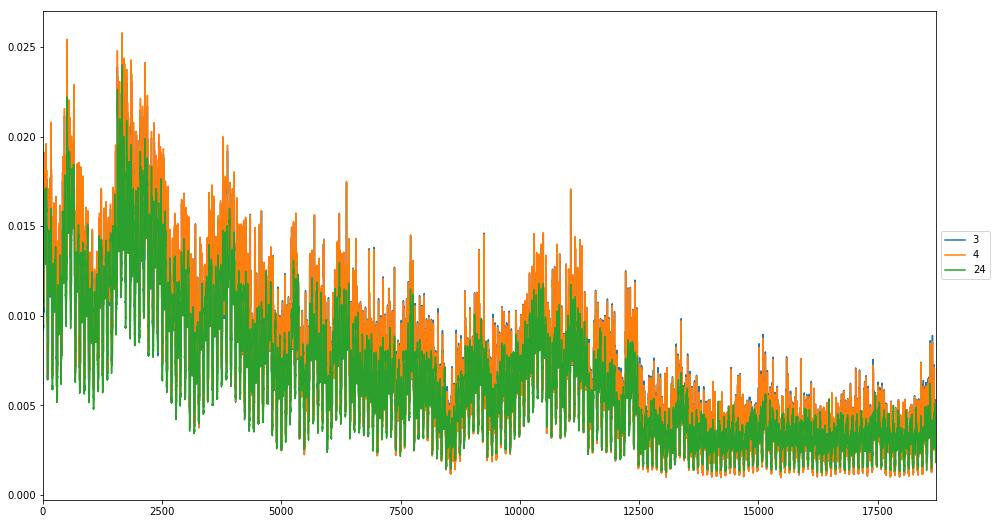

In [16]:
if len(houses_with_hp) > 0:    
    ax1 = plt.subplot()

    for column in df_main.columns:
        if column in houses_with_hp:
            df_main[column].plot(figsize = (16,9), ax = ax1)
    plt.legend()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(OUTPUT + SZENARIO + '/houses_with_hp.png')    
    plt.show()


In [17]:
#Include Home Storage
#To be included: Compare d.grid_demand to charge_power and (dis-)charge with a max of charge_power. 
#Rest goes to/comes from grid
if len(houses_with_storage) > 0:
    df_main.set_index(df_main.Time, inplace = True)#index needs to be set for home storage
    del df_main['Time']
    df = pd.DataFrame(df_main.index) #reset dataframe for next loop
    df.set_index(df.Time, inplace = True)
    del df['Time']
    df_Storage_Charge = pd.DataFrame(df_main.index) #dataframe for storage demand

    for column in df_main.columns:   

        if column in houses_with_storage:

            #add data to processing data frame. Battery model handels generation positive, demand negative
            df['House_Demand'] = -1*df_main[column] 
            lst_storage = []
            lst_demand = []
            storage_charge = init_storage_charge
            rest = 0 #reset

            for i, d in df.iterrows():

                #If the house would feed electricity into the grid, charge the storage first. 
                #No electricity exchange with grid as long as charger power is not ecxeeded
                if (d.House_Demand > 0) & (storage_charge < storage_max):

                    #Check if energy produced exceeds charger power
                    if (d.House_Demand < charger_power):
                        storage_charge = storage_charge + (d.House_Demand * 0.98 * time_base)
                        rest = 0
                    #If it does, feed the rest to the grid
                    else:
                        storage_charge = storage_charge + (charger_power * 0.98 * time_base)
                        rest = d.House_Demand - charger_power

                    #If the storage would be overcharged, feed the 'rest' to the grid
                    if (storage_charge > storage_max):                                  
                        rest = ((storage_charge - storage_max)/ time_base)
                        storage_charge = storage_max

                #If the house needs electricity from the grid, discharge the storage first. 
                #In this case d.House_Demand is negative! 
                #No electricity exchange with grid as long as demand does not exceed charger power
                elif (d.House_Demand < 0) & (storage_charge > 0):

                    #Check if energy demand exceeds charger power
                    if (d.House_Demand < (charger_power * -1)):
                        storage_charge = (storage_charge) - (charger_power * 1.02 * time_base)
                        rest = d.House_Demand + charger_power

                    else:
                        storage_charge = (storage_charge)  + (d.House_Demand * 1.02 * time_base)
                        rest = 0

                    #If the storage would be undercharged, take the 'rest' from the grid
                    if (storage_charge < 0):  
                        #since storage_charge is negative in this case it can be taken as demand
                        rest = (storage_charge / time_base) #kWh / h = kW
                        storage_charge = 0

                #If the storage is full or empty, the demand is not affected
                #elif(storage_charge == 0) | (storage_charge == storage_max):
                else:
                    rest = d.House_Demand


                lst_storage.append(storage_charge)
                lst_demand.append(rest*-1)

            df_storage = pd.DataFrame(lst_storage)
            df_Storage_Charge[column] = df_storage[0]
            df_main[column] = lst_demand
    df_Storage_Charge.set_index(df_Storage_Charge.Time, inplace = True)
    del df_Storage_Charge['Time']
    df_Storage_Charge.to_pickle(OUTPUT + SZENARIO +'/df_Storage_Charge.pkl')

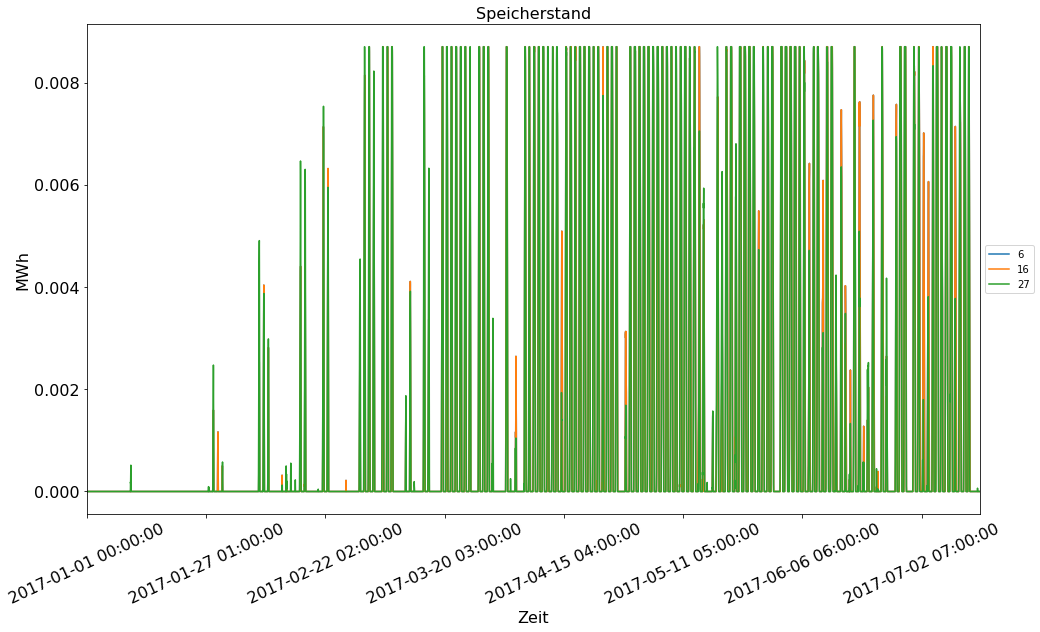

In [18]:
if len(houses_with_storage) > 0:
    ax1 = plt.subplot()
    #df_Storage_Charge.set_index(df_Storage_Charge.Time, inplace = True)
    #df_Storage_Charge.ix['2017-06-01 00:00:00':'2017-06-08 23:00:00'].plot(figsize=(16,9), ax = ax1)
    df_Storage_Charge.plot(figsize=(16,9), ax = ax1)
    
    #plt.axhline(y=charger_power, color='r', linestyle='-', label = 'Charger Max')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(25)
    plt.ylabel("MWh", fontsize = fontsize)
    plt.xlabel("Zeit", fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.title("Speicherstand", fontsize = fontsize)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(OUTPUT + SZENARIO + '/df_Storage_Charge.png')
    plt.show()   

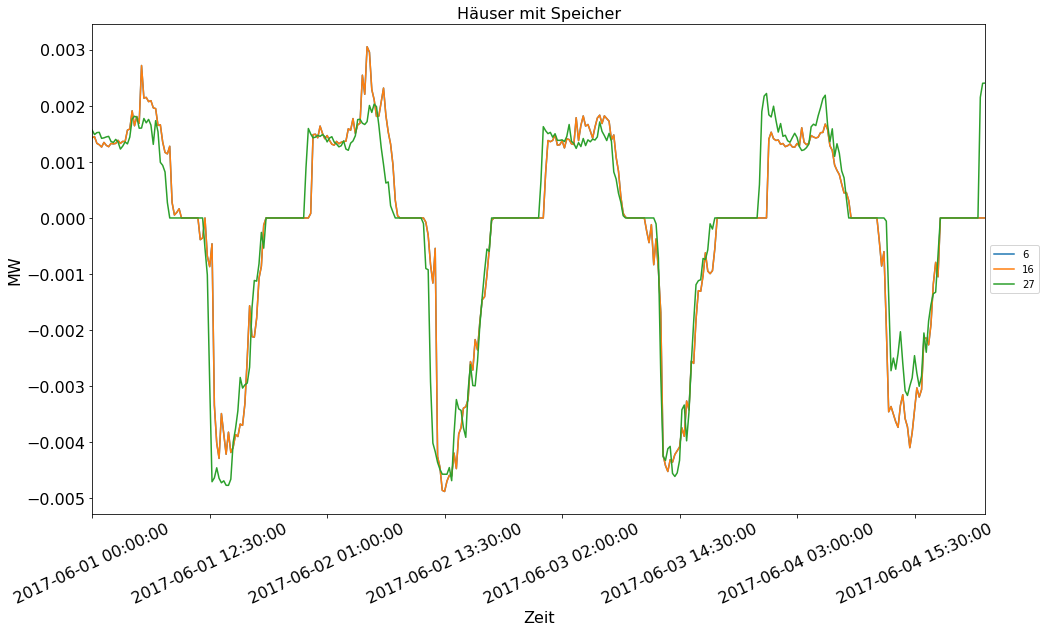

In [19]:
if len(houses_with_storage) > 0:
    ax1 = plt.subplot()

    for column in df_main.columns:
        if column in houses_with_storage:
            df_main[column].ix['2017-06-01 00:00:00':'2017-06-04 23:00:00'].plot(figsize = (16,9), ax = ax1)
            #df_main[column].plot(figsize = (16,9), ax = ax1)

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(25)
    plt.ylabel("MW", fontsize = fontsize)
    plt.xlabel("Zeit", fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.title("Häuser mit Speicher", fontsize = fontsize)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(OUTPUT + SZENARIO + '/houses_with_storage.png')  
    plt.show()  

In [20]:
if 'Time' in df_main.columns:
    df_main.set_index(df_main.Time, inplace = True)
    del df_main['Time']
    df_main

In [21]:
df_main

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.013356,0.002356,0.009290,0.009577,0.002356,0.002260,0.002260,0.002260,0.002260,0.002260,...,0.002889,0.002889,0.002173,0.009393,0.002173,0.002173,0.002173,0.002173,0.002173,0.015322
2017-01-01 00:15:00,0.014203,0.003203,0.010136,0.010423,0.003203,0.002173,0.002173,0.002173,0.002173,0.002173,...,0.001973,0.001973,0.002000,0.009220,0.002000,0.002000,0.002000,0.002000,0.002000,0.015829
2017-01-01 00:30:00,0.014044,0.003044,0.009978,0.010265,0.003044,0.002044,0.002044,0.002044,0.002044,0.002044,...,0.002235,0.002235,0.002112,0.009332,0.002112,0.002112,0.002112,0.002112,0.002112,0.015117
2017-01-01 00:45:00,0.014379,0.003379,0.010312,0.010600,0.003379,0.002003,0.002003,0.002003,0.002003,0.002003,...,0.002021,0.002021,0.002179,0.009399,0.002179,0.002179,0.002179,0.002179,0.002179,0.015275
2017-01-01 01:00:00,0.012563,0.003038,0.010215,0.010512,0.003038,0.001866,0.001866,0.001866,0.001866,0.001866,...,0.001857,0.001857,0.002119,0.009593,0.002119,0.002119,0.002119,0.002119,0.002119,0.015304
2017-01-01 01:15:00,0.003803,0.003803,0.010980,0.011277,0.003803,0.001771,0.001771,0.001771,0.001771,0.001771,...,0.001943,0.001943,0.001820,0.009294,0.001820,0.001820,0.001820,0.001820,0.001820,0.014717
2017-01-01 01:30:00,0.003766,0.003766,0.010943,0.011241,0.003766,0.001970,0.001970,0.001970,0.001970,0.001970,...,0.001667,0.001667,0.002021,0.009496,0.002021,0.002021,0.002021,0.002021,0.002021,0.014940
2017-01-01 01:45:00,0.003972,0.003972,0.011149,0.011446,0.003972,0.001769,0.001769,0.001769,0.001769,0.001769,...,0.001631,0.001631,0.001698,0.009172,0.001698,0.001698,0.001698,0.001698,0.001698,0.014891
2017-01-01 02:00:00,0.003526,0.003526,0.010891,0.011196,0.003526,0.001907,0.001907,0.001907,0.001907,0.001907,...,0.001432,0.001432,0.001785,0.009455,0.001785,0.001785,0.001785,0.001785,0.001785,0.015031


In [22]:
#Export loadshapes
df_main.to_csv(OUTPUT + SZENARIO +'/loads-p_set.csv')

In [23]:
#df_main.to_pickle(OUTPUT + SZENARIO +'/loads-p_set.pkl')

In [24]:
#Processingtime in minutes
end = time.time()
(end-start)/60

4.781993647416432